In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
import matplotlib as mpl
import scanpy as sc

from goatools.base import download_go_basic_obo
from goatools.base import gunzip

from genes_ncbi_homo_sapiens_proteincoding import GENEID2NT as GeneID2nt_hs

from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

from adjustText import adjust_text
from anndata import AnnData
from typing import Union

### 1. Prepare data

In [3]:
class DataProcessor:
    def __init__(
        self,
        raw_counts: pd.DataFrame,
        classes: list[str],
        n_cpus: int,
        batches: list[str] = None,
    ):
        self.raw_counts = raw_counts
        self.classes = classes
        self.batches = batches
        self.n_cpus = n_cpus

    def prepare_counts_metadata(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        A method that checks if the list of batches was provided.
        If there are no batches, it checks the number of classes and subsets samples that belong to the classes,
        then it will prepare filtered counts and metadata. Otherwise, it will subset by class and batch and check
        if only one class was provided. Multiple batch comparisons are implemented here as only per one class!

        Returns tuple of counts and metadata

        """
        local_raw_counts = self.raw_counts.copy(deep=True)

        local_raw_counts["class"] = [
            gene.split("_")[2] for gene in local_raw_counts.index
        ]  # Retrieve class name if the sample name as TA001_batch_class_replica
        local_raw_counts["batch"] = [
            gene.split("_")[1] for gene in local_raw_counts.index
        ]  # Retrieve batch number if the sample name as TA001_batch_class_replica

        if not self.batches:
            assert (
                len(self.classes) == 2
            ), "prepare_counts_metadata() only take list with two class as a condition."
            samples_to_keep = local_raw_counts["class"].isin(self.classes)
        else:
            assert (
                len(self.classes) == 1
            ), "prepare_counts_metadata_batch_comparison_per_class() only take list with one class (str) as a condition."
            samples_to_keep = local_raw_counts["batch"].isin(
                self.batches
            ) & local_raw_counts["class"].isin(
                self.classes
            )  # Must provide only one class

        # Generate metadata
        counts_ = local_raw_counts.loc[
            samples_to_keep
        ]  # local_raw_counts still has class and batch columns
        if not self.batches:
            metadata = counts_["class"].to_frame(name="condition")
        else:
            metadata = counts_["class"].to_frame(name="condition")
            metadata["group"] = counts_["batch"]

        filtered_counts = self.raw_counts[
            samples_to_keep
        ]  # raw_counts does not have class and batch columns

        # Filtering genes that has total sum lower than 10
        genes_to_keep = filtered_counts.columns[filtered_counts.sum(axis=0) >= 10]
        out_counts = filtered_counts[genes_to_keep]

        return out_counts, metadata

    def make_dds(self) -> AnnData:
        if not self.batches:
            counts, metadata = self.prepare_counts_metadata()
        else:
            counts, metadata = self.prepare_counts_metadata_batch_comparison_per_class()

        dds = DeseqDataSet(
            counts=counts,
            metadata=metadata,
            design_factors=metadata.columns,
            refit_cooks=True,
            inference=DefaultInference(self.n_cpus),
        )

        dds.deseq2()

        return dds

    def make_statistics(
        self,
        padj_value: float = 0.05,
        log2foldchange_value: int = 2,
    ) -> tuple[AnnData, pd.DataFrame, pd.DataFrame]:
        dds = self.make_dds()

        if not self.batches:
            conditions_to_contrast = self.classes
            design_factor = "condition"
        else:
            conditions_to_contrast = self.batches
            design_factor = "group"

        stat_res = DeseqStats(
            dds,
            contrast=(design_factor, *conditions_to_contrast),
            inference=DefaultInference(self.n_cpus),
            quiet=True,
        )

        stat_res.summary()

        res = stat_res.results_df
        res = res[res.baseMean >= 10]
        sigs = res[
            (res.padj < padj_value) & (abs(res.log2FoldChange) > log2foldchange_value)
        ]

        return dds, res, sigs

### 2. Make histogram

In [4]:
def make_historgram_for_sign_genes(
    dds: AnnData,
    sigs: pd.DataFrame,
    results_directory: str,
    analysis_name: str,
    num_top_sig: Union[int, str],
) -> None:
    if num_top_sig != "all":
        sigs = sigs.sort_values("padj")[
            :num_top_sig
        ]  # num_top_sig can take all to plot all genes

    dds_sigs = dds[:, sigs.index]
    dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])

    grapher = pd.DataFrame(
        dds_sigs.layers["log1p"].T, index=dds_sigs.var_names, columns=dds_sigs.obs_names
    )

    plt.figure(figsize=(12, 12))
    sns.set_theme(
        context="notebook",
        style="darkgrid",
        palette="deep",
        font="sans-serif",
        font_scale=0.55,
        color_codes=True,
        rc=None,
    )

    sns.clustermap(grapher, z_score=0, cmap="RdYlBu_r")
    plt.title(analysis_name)

    plt.savefig(
        f"{results_directory}/{analysis_name}_histo_sign.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

### 3. Make GO term analysis

In [5]:
def initialise_go() -> None:
    # obo_fname = download_go_basic_obo()  # Already downloaded the go-basic.obo
    # fin_gene2go = gunzip("gene2go.gz")  # Already unzipped the file

    fin_gene2go = os.path.join(path_to_supporting_files, "gene2go")
    obodag = GODag(os.path.join(path_to_supporting_files, "go-basic.obo"))

    mapper = {}
    for key in GeneID2nt_hs:
        mapper[GeneID2nt_hs[key].Symbol] = GeneID2nt_hs[key].GeneID

    objanno = Gene2GoReader(fin_gene2go, taxids=[9606])

    """
    Get namespace2association where:
       namespace is:
           BP: biological_process
           MF: molecular_function
           CC: cellular_component
       assocation is a dict:
           key: NCBI GeneID
           value: A set of GO IDs associated with that gene
    """
    ns2assoc = objanno.get_ns2assc()

    goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_hs.keys(),  # List of human protein-coding genes
        ns2assoc,  # Geneid/GO associations
        obodag,  # Ontologies
        propagate_counts=False,
        alpha=0.05,  # Default significance cut-off
        methods=["fdr_bh"],  # Default multipletest correction method
    )

    go_items = []

    temp = goeaobj.ns2objgoea["BP"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["CC"].assoc
    for item in temp:
        go_items += temp[item]

    temp = goeaobj.ns2objgoea["MF"].assoc
    for item in temp:
        go_items += temp[item]

    return mapper, goeaobj, go_items


def go_it(test_genes: list[str], mapper, goeaobj, go_items):
    print(f"input genes: {len(test_genes)}")

    inv_map = {v: k for k, v in mapper.items()}

    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f"mapped genes: {len(mapped_genes)}")

    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

    GO = pd.DataFrame(
        list(
            map(
                lambda x: [
                    x.GO,
                    x.goterm.name,
                    x.goterm.namespace,
                    x.p_uncorrected,
                    x.p_fdr_bh,
                    x.ratio_in_study[0],
                    x.ratio_in_study[1],
                    go_items.count(x.GO),
                    list(map(lambda y: inv_map[y], x.study_items)),
                    x.ratio_in_study[0] / go_items.count(x.GO),
                ],
                goea_results_sig,
            )
        ),
        columns=[
            "GO",
            "term",
            "class",
            "p",
            "p_corr",
            "n_genes",
            "n_study",
            "n_go",
            "study_genes",
            "per",
        ],
    )

    GO = GO[GO.n_genes > 1]
    return GO


def make_go_plot(df, results_directory, analysis_name):
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = mpl.cm.bwr_r
    norm = mpl.colors.Normalize(vmin=df.p_corr.min(), vmax=df.p_corr.max())
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    sns.barplot(
        data=df,
        x="per",
        y="term",
        palette=list(mapper.to_rgba(df.p_corr.values)),
        ax=ax,
    )
    ax.set_yticklabels([textwrap.fill(e, 30) for e in df["term"]])

    cbar = fig.colorbar(mapper, ax=ax, orientation="vertical", pad=0.01)
    cbar.ax.set_position([0.8, 0.5, 0.2, 0.3])
    plt.title(analysis_name)

    plt.savefig(
        f"{results_directory}/{analysis_name}_go.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

In [6]:
mapper, goeaobj, go_items = initialise_go()

go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms
HMS:0:01:00.840359 346,071 annotations, 20,759 genes, 18,733 GOs, 1 taxids READ: gene2go 

Load BP Ontology Enrichment Analysis ...
 83% 17,024 of 20,615 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,139 of 20,615 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,598 of 20,615 population items found in association


### 4. Make Volcano plot

4.1 With shapes designating genes of interest

In [7]:
# genes_of_interest_path = (
#     "/home/t.afanasyeva/MATseq/notebooks/DeSeq2/immuno_gene_symbols.txt"
# )
# immunoresponse_gene_df = pd.read_csv(genes_of_interest_path, sep="\t")
# immunoresponse_genes = set(immunoresponse_gene_df["Approved symbol"])


# def map_color(gene, overexpressed, underexpressed):
#     if gene in overexpressed:
#         return "overexpressed"
#     elif gene in underexpressed:
#         return "underexpressed"
#     else:
#         return "no_expression_change"


# def map_shape(gene, immunoresponse_genes):
#     if gene in immunoresponse_genes:
#         return "immunoresponse"
#     else:
#         return "no_immunoresponse"


# def make_volcano_plot(
#     res: pd.DataFrame,
#     genes_of_interest: set[str],
#     results_directory: str,
#     analysis_name: str,
#     sign_log2FoldChange: int = 2,
#     sign_padj: float = 0.05,
# ) -> None:
#     sign_genes = res[(res["padj"] < sign_padj)]
#     overexpressed = list(
#         sign_genes[(sign_genes["log2FoldChange"] > sign_log2FoldChange)].index
#     )
#     underexpressed = list(
#         sign_genes[(sign_genes["log2FoldChange"] < -sign_log2FoldChange)].index
#     )

#     df = res.reset_index(names="gene")
#     df["padj_log"] = -np.log10(df["padj"])

#     df["color"] = df.apply(
#         lambda row: map_color(row["gene"], overexpressed, underexpressed),
#         axis=1,
#     )

#     df["shape"] = df.apply(
#         lambda row: map_shape(row["gene"], genes_of_interest),
#         axis=1,
#     )

#     plt.figure(figsize=(10, 12))
#     custom_params = {"axes.spines.right": False, "axes.spines.top": False}
#     sns.set_theme(context="notebook", style="white", rc=custom_params)
#     plt.title(analysis_name)

#     ax = sns.scatterplot(
#         data=df,
#         x="log2FoldChange",
#         y="padj_log",
#         hue="color",
#         hue_order=["no_expression_change", "overexpressed", "underexpressed"],
#         palette=["grey", "orange", "purple"],
#         style="shape",
#         style_order=["immunoresponse", "no_immunoresponse"],
#         markers=["s", "o"],
#         size="baseMean",
#         sizes=(20, 200),
#     )

#     ax.axhline(1.3, zorder=1, c="k", lw=1, ls="--")
#     ax.axvline(2, zorder=1, c="k", lw=1, ls="--")
#     ax.axvline(-2, zorder=1, c="k", lw=1, ls="--")

#     ax.tick_params(width=2)

#     texts = []
#     for i in range(len(df)):
#         if (
#             df.iloc[i].padj < sign_padj
#             and abs(df.iloc[i].log2FoldChange) > sign_log2FoldChange
#         ):
#             texts.append(
#                 plt.text(
#                     x=df.iloc[i].log2FoldChange,
#                     y=df.iloc[i].padj_log,
#                     s=df.iloc[i].gene,
#                     fontsize=10,
#                     weight="bold",
#                 )
#             )

#     adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k"))
#     plt.legend(loc=1, bbox_to_anchor=(1.3, 1), frameon=False, prop={"weight": "bold"})

#     plt.xticks(size=10, weight="bold")
#     plt.yticks(size=10, weight="bold")

#     plt.xlabel("$log_{2}$ fold change")
#     plt.ylabel("-$log_{10}$ FDR")

#     plt.savefig(
#         f"{results_directory}/{analysis_name}_volcano.png",
#         dpi=300,
#         bbox_inches="tight",
#         facecolor="white",
#     )

4.2 Without shapes

In [8]:
def map_color(gene, overexpressed, underexpressed):
    if gene in overexpressed:
        return "overexpressed"
    elif gene in underexpressed:
        return "underexpressed"
    else:
        return "no_expression_change"


def make_volcano_plot(
    res: pd.DataFrame,
    results_directory: str,
    analysis_name: str,
    sign_log2FoldChange: int = 2,
    sign_padj: float = 0.05,
) -> None:
    sign_genes = res[(res["padj"] < sign_padj)]
    overexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] > sign_log2FoldChange)].index
    )
    underexpressed = list(
        sign_genes[(sign_genes["log2FoldChange"] < -sign_log2FoldChange)].index
    )

    df = res.reset_index(names="gene")
    df["padj_log"] = -np.log10(df["padj"])

    df["color"] = df.apply(
        lambda row: map_color(row["gene"], overexpressed, underexpressed),
        axis=1,
    )

    plt.figure(figsize=(10, 12))
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(context="notebook", style="white", rc=custom_params)
    plt.title(analysis_name)

    ax = sns.scatterplot(
        data=df,
        x="log2FoldChange",
        y="padj_log",
        hue="color",
        hue_order=["no_expression_change", "overexpressed", "underexpressed"],
        palette=["grey", "orange", "purple"],
        size="baseMean",
        sizes=(20, 200),
    )

    ax.axhline(1.3, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(2, zorder=1, c="k", lw=1, ls="--")
    ax.axvline(-2, zorder=1, c="k", lw=1, ls="--")

    ax.tick_params(width=2)

    texts = []
    for i in range(len(df)):
        if (
            df.iloc[i].padj < sign_padj
            and abs(df.iloc[i].log2FoldChange) > sign_log2FoldChange
        ):
            texts.append(
                plt.text(
                    x=df.iloc[i].log2FoldChange,
                    y=df.iloc[i].padj_log,
                    s=df.iloc[i].gene,
                    fontsize=10,
                    weight="bold",
                )
            )

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k"))
    plt.legend(loc=1, bbox_to_anchor=(1.3, 1), frameon=False, prop={"weight": "bold"})

    plt.xticks(size=10, weight="bold")
    plt.yticks(size=10, weight="bold")

    plt.xlabel("$log_{2}$ fold change")
    plt.ylabel("-$log_{10}$ FDR")

    plt.savefig(
        f"{results_directory}/{analysis_name}_volcano.png",
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

### 5. Make PCA, t-SNE, umap

In [9]:
def make_pca(
    dds: AnnData,
    results_directory: str,
    analysis_name: str,
) -> None:
    sc.tl.pca(dds, n_comps=2)
    pca = dds.obsm["X_pca"]
    sample_names = list(sc.get.obs_df(dds).index)  # get sample names
    sns.set_theme(
        context="notebook",
        style="white",
        palette="deep",
        font="sans-serif",
        font_scale=0.6,
        color_codes=True,
        rc=None,
    )

    plt.figure(figsize=(12, 12))
    ax = sc.pl.pca(
        dds, title=f"PCA_{analysis_name}", color="condition", size=300, show=False
    )  # color can also be group

    plt.tight_layout(w_pad=2)
    plt.savefig(f"{results_directory}/pca_{analysis_name}.png")

    texts = [
        plt.text(pca[i][0], pca[i][1], sample_names[i], ha="left", va="bottom")
        for i in range(len(pca))
    ]

    plt.savefig(f"{results_directory}/pca_{analysis_name}_annotated.png")


def make_tsne(
    dds: AnnData,
    results_directory: str,
    analysis_name: str,
) -> None:
    sc.tl.tsne(dds, n_pcs=2)
    tsne = dds.obsm["X_tsne"]
    sample_names = list(sc.get.obs_df(dds).index)  # get sample names
    sns.set_theme(
        context="notebook",
        style="white",
        palette="deep",
        font="sans-serif",
        font_scale=0.6,
        color_codes=True,
        rc=None,
    )

    plt.figure(figsize=(12, 12))
    ax = sc.pl.tsne(
        dds, title=f"t-SNE_{analysis_name}", color="condition", size=300, show=False
    )  # color can also be group

    plt.tight_layout(w_pad=2)
    plt.savefig(f"{results_directory}/tsne_{analysis_name}.png")

    texts = [
        plt.text(tsne[i][0], tsne[i][1], sample_names[i], ha="left", va="bottom")
        for i in range(len(tsne))
    ]

    plt.savefig(f"{results_directory}/tsne_{analysis_name}_annotated.png")


def make_umap(
    dds: AnnData,
    results_directory: str,
    analysis_name: str,
) -> None:
    sc.pp.neighbors(dds)
    sc.tl.umap(dds)
    umap = dds.obsm["X_umap"]
    sample_names = list(sc.get.obs_df(dds).index)  # get sample names
    sns.set_theme(
        context="notebook",
        style="white",
        palette="deep",
        font="sans-serif",
        font_scale=0.6,
        color_codes=True,
        rc=None,
    )

    plt.figure(figsize=(12, 12))
    ax = sc.pl.umap(
        dds, title=f"umap_{analysis_name}", color="condition", size=300, show=False
    )  # color can also be group

    plt.tight_layout(w_pad=2)
    plt.savefig(f"{results_directory}/umap_{analysis_name}.png")

    texts = [
        plt.text(umap[i][0], umap[i][1], sample_names[i], ha="left", va="bottom")
        for i in range(len(umap))
    ]

    plt.savefig(f"{results_directory}/umap_{analysis_name}_annotated.png")

In [10]:
# index_col="sample"
# index_col="Unnamed: 0"

In [15]:
file_path = "/home/t.afanasyeva/MAT_rnaseq/gene_counts/20240224_complete_dataset_273_samples.csv"
raw_counts = pd.read_csv(file_path, index_col="Unnamed: 0")

In [17]:
raw_counts

DDX11L1  WASH7P  MIR6859-1  MIR1302-2HG  MIR1302-2  \
MD104_7128_SCG_1             0      10          1            0          0   
MD104_7128_SCG_2             0      12          0            0          0   
MD104_7128_SCG_3             0      19          1            0          0   
MD104_7128_SCG-L_1           0      13          0            0          0   
MD104_7128_SCG-L_2           0      10          3            0          0   
...                        ...     ...        ...          ...        ...   
MD251_7128_CL307_20          0      76          0            0          0   
MD251_7128_CL307_21          0      29          0            0          0   
MD251_7128_CRX-527_22        0      59          1            0          0   
MD251_7128_CRX-527_23        0      29          0            0          0   
MD251_7128_CRX-527_24        0      28          0            0          0   

                       FAM138A  OR4F5  LOC124903816  LOC124900384  LOC729737  \
MD104_7128_SCG_1             0      0             0             0         44   
MD104_7128_SCG_2             0      0             0             2         36   
MD104_7128_SCG_3             0      0             0             2         50   
MD104_7128_SCG-L_1           0      0             0             0         46   
MD104_7128_SCG-L_2           0      0             0             4         40   
...                        ...    ...           ...           ...        ...   
MD251_7128_CL307_20          0      0             1             3         61   
MD251_7128_CL307_21          0      0             0             6         24   
MD251_7128_CRX-527_22        0      0             0             3         34   
MD251_7128_CRX-527_23        0      0             0             1         32   
MD251_7128_CRX-527_24        0      0             1             2         25   

                       ...    ND4  TRNH  TRNS2  TRNL2   ND5   ND6  TRNE  CYTB  \
MD104_7128_SCG_1       ...   3311     0      0      0  2569   910     1  2125   
MD104_7128_SCG_2       ...   4705     0      0      1  3495  1053     7  2975   
MD104_7128_SCG_3       ...   4138     1      1      1  2858  1018     1  2463   
MD104_7128_SCG-L_1     ...   3590     1      0      2  2885   959     3  2141   
MD104_7128_SCG-L_2     ...   4071     1      0      0  2974  1060     4  2445   
...                    ...    ...   ...    ...    ...   ...   ...   ...   ...   
MD251_7128_CL307_20    ...  11837     1      1      3  8083  2174     6  7180   
MD251_7128_CL307_21    ...   7868     0      0      3  5639  1518     1  4764   
MD251_7128_CRX-527_22  ...   9413     0      0      2  6481  1732    10  5854   
MD251_7128_CRX-527_23  ...   6110     1      0      1  3902  1079     2  3339   
MD251_7128_CRX-527_24  ...   7845     0      1      1  5096  1546     2  4495   

                       TRNT  TRNP  
MD104_7128_SCG_1          0    41  
MD104_7128_SCG_2          0    51  
MD104_7128_SCG_3          0    53  
MD104_7128_SCG-L_1        0    55  
MD104_7128_SCG-L_2        0    54  
...                     ...   ...  
MD251_7128_CL307_20       0   130  
MD251_7128_CL307_21       1    96  
MD251_7128_CRX-527_22     0   105  
MD251_7128_CRX-527_23     0    67  
MD251_7128_CRX-527_24     0    74  

[273 rows x 47698 columns]

In [18]:
class_list = [i.split("_")[2] for i in raw_counts.index]

In [19]:
set(class_list)

{'Alb2',
 'Albu',
 'CL307',
 'CL8',
 'CRX-527',
 'FLA-ST',
 'FSL-1',
 'Fab',
 'Fla-PA',
 'Fla-ST',
 'HKEB',
 'HKSA',
 'IMDM',
 'LPS',
 'LPS-PGN',
 'LPS-R848',
 'LPS-SM',
 'LTA',
 'LTA-BS',
 'MPLA',
 'Mur',
 'PGN',
 'Pam2',
 'Pam3',
 'Pam3-PGN',
 'Pam3-R848',
 'R848',
 'R848-low',
 'SCG',
 'SCG-L',
 'TL8',
 'cAlb',
 'clean',
 'cleared',
 'contaminated'}

In [20]:
len(set(class_list))

35

In [21]:
# raw_counts["batch"] = [
#     gene.split("_")[1] for gene in raw_counts.index
# ]  # Retrieve batch number if the sample name as TA001_batch_class_replica
# batches = set(raw_counts["batch"])
# class_to_check = ["IMDM"]

# count, meta = prepare_counts_metadata_batch_comparison_per_class(
#     raw_counts, class_to_check, batches
# )

In [22]:
list_of_classes_to_include = []

for my_class in set(class_list):
    if my_class != "IMDM":
        list_of_classes_to_include.append((my_class, "IMDM"))

In [23]:
current_directory = os.getcwd()

### 6. Run analysis

Fitting size factors...
... done in 0.02 seconds.

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  28 tasks      | elapsed:    0.1s
[Par

Log2 fold change & Wald test p-value: condition Alb2 vs IMDM
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P           82.730716        0.182593  0.192105  0.950484  0.341867   
MIR6859-1         2.563212       -0.610410  0.549408 -1.111031  0.266555   
LOC124903816      0.681225       -0.309833  1.086373 -0.285199  0.775491   
LOC124900384      4.184444        0.680816  0.311043  2.188816  0.028610   
LOC729737        85.540986        0.068702  0.285933  0.240273  0.810119   
...                    ...             ...       ...       ...       ...   
ND6            3981.232565       -0.663547  0.233844 -2.837560  0.004546   
TRNE             17.062655       -0.348082  0.251217 -1.385582  0.165875   
CYTB          11393.356038       -0.386720  0.187631 -2.061067  0.039297   
TRNT              1.708907        0.511459  0.470109  1.087958  0.276614   
TRNP            220.059648       -0.292787  0.243314 -1.203333  0.228848   

                  padj  
W

/tmp/ipykernel_2600715/4226293107.py:14: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


input genes: 132
mapped genes: 108

Runing BP Ontology Analysis: current study set of 108 IDs.
 94%    102 of    108 study items found in association
100%    108 of    108 study items found in population(20615)
Calculating 12,180 uncorrected p-values using fisher_scipy_stats
  12,180 terms are associated with 17,024 of 20,615 population items
   1,092 terms are associated with    102 of    108 study items
  METHOD fdr_bh:
      47 GO terms found significant (< 0.05=alpha) ( 47 enriched +   0 purified): statsmodels fdr_bh
      65 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 108 IDs.
 97%    105 of    108 study items found in association
100%    108 of    108 study items found in population(20615)
Calculating 1,801 uncorrected p-values using fisher_scipy_stats
   1,801 terms are associated with 18,139 of 20,615 population items
     151 terms are associated 

Fitting size factors...
... done in 0.02 seconds.

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done   6 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  12 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  20 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  22 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=96)]: Done  28 tasks      | elapsed:    0.6s
[Par

Log2 fold change & Wald test p-value: condition TL8 vs IMDM
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P           80.999547       -0.031243  0.193988 -0.161058  0.872048   
MIR6859-1         2.615540       -0.092877  0.494686 -0.187749  0.851074   
LOC124903816      0.654163       -1.128939  1.235220 -0.913958  0.360739   
LOC124900384      3.883606       -0.264448  0.384353 -0.688032  0.491432   
LOC729737        81.760831       -0.704762  0.293971 -2.397386  0.016513   
...                    ...             ...       ...       ...       ...   
ND6            4086.588944        0.009008  0.233708  0.038542  0.969256   
TRNE             17.853190        0.481738  0.236312  2.038566  0.041493   
CYTB          11662.847637        0.153694  0.188138  0.816921  0.413973   
TRNT              1.697252        0.524671  0.511597  1.025556  0.305101   
TRNP            220.052810       -0.155001  0.243348 -0.636952  0.524156   

                  padj  
WA

/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


input genes: 26
mapped genes: 20

Runing BP Ontology Analysis: current study set of 20 IDs.
 95%     19 of     20 study items found in association
100%     20 of     20 study items found in population(20615)
Calculating 12,180 uncorrected p-values using fisher_scipy_stats
  12,180 terms are associated with 17,024 of 20,615 population items
     508 terms are associated with     19 of     20 study items
  METHOD fdr_bh:
      42 GO terms found significant (< 0.05=alpha) ( 42 enriched +   0 purified): statsmodels fdr_bh
      16 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 20 IDs.
 95%     19 of     20 study items found in association
100%     20 of     20 study items found in population(20615)
Calculating 1,801 uncorrected p-values using fisher_scipy_stats
   1,801 terms are associated with 18,139 of 20,615 population items
      37 terms are associated with

Fitting size factors...
... done in 0.03 seconds.

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  28 tasks      | elapsed:    0.1s
[Par

Log2 fold change & Wald test p-value: condition R848-low vs IMDM
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
WASH7P           69.267666       -0.450745  0.127043 -3.547968  3.882152e-04   
MIR6859-1         2.229487       -0.833621  0.400632 -2.080767  3.745520e-02   
LOC124903816      0.650276       -0.146341  0.756014 -0.193569  8.465132e-01   
LOC124900384      3.670832        0.143006  0.273967  0.521983  6.016820e-01   
LOC729737        82.745072        0.313987  0.161551  1.943573  5.194697e-02   
...                    ...             ...       ...       ...           ...   
ND6            3947.069854        0.224408  0.121990  1.839561  6.583269e-02   
TRNE             18.848627        0.840727  0.165888  5.068050  4.019120e-07   
CYTB          11117.858611        0.206550  0.099090  2.084479  3.711663e-02   
TRNT              1.901002        0.501605  0.406313  1.234529  2.170059e-01   
TRNP            228.922134        0.521344  0.134119  3

/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


input genes: 212
mapped genes: 181

Runing BP Ontology Analysis: current study set of 181 IDs.
 95%    172 of    181 study items found in association
100%    181 of    181 study items found in population(20615)
Calculating 12,180 uncorrected p-values using fisher_scipy_stats
  12,180 terms are associated with 17,024 of 20,615 population items
   1,193 terms are associated with    172 of    181 study items
  METHOD fdr_bh:
      75 GO terms found significant (< 0.05=alpha) ( 75 enriched +   0 purified): statsmodels fdr_bh
     116 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 181 IDs.
 98%    177 of    181 study items found in association
100%    181 of    181 study items found in population(20615)
Calculating 1,801 uncorrected p-values using fisher_scipy_stats
   1,801 terms are associated with 18,139 of 20,615 population items
     182 terms are associated 

Fitting size factors...
... done in 0.02 seconds.

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  28 tasks      | elapsed:    0.1s
[Par

Log2 fold change & Wald test p-value: condition SCG vs IMDM
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P          61.069514       -0.108342  0.160408 -0.675411  0.499415   
MIR6859-1        1.971960       -0.606425  0.548968 -1.104665  0.269305   
LOC124903816     0.431305       -0.235033  1.190741 -0.197384  0.843527   
LOC124900384     3.150894        0.075196  0.391890  0.191880  0.847836   
LOC729737       72.109493        0.586810  0.280923  2.088866  0.036720   
...                   ...             ...       ...       ...       ...   
ND6           3214.899449        0.167350  0.163180  1.025556  0.305101   
TRNE            13.889117        0.116081  0.265852  0.436639  0.662373   
CYTB          9126.176145        0.194381  0.123462  1.574416  0.115391   
TRNT             1.288899       -0.144941  0.633581 -0.228765  0.819051   
TRNP           174.645949        0.138591  0.186244  0.744136  0.456794   

                  padj  
WASH7P        

/tmp/ipykernel_2600715/4226293107.py:14: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


input genes: 40
mapped genes: 31

Runing BP Ontology Analysis: current study set of 31 IDs.
 94%     29 of     31 study items found in association
100%     31 of     31 study items found in population(20615)
Calculating 12,180 uncorrected p-values using fisher_scipy_stats
  12,180 terms are associated with 17,024 of 20,615 population items
     634 terms are associated with     29 of     31 study items
  METHOD fdr_bh:
      76 GO terms found significant (< 0.05=alpha) ( 76 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 31 IDs.
 97%     30 of     31 study items found in association
100%     31 of     31 study items found in population(20615)
Calculating 1,801 uncorrected p-values using fisher_scipy_stats
   1,801 terms are associated with 18,139 of 20,615 population items
      62 terms are associated with

Fitting size factors...
... done in 0.02 seconds.

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  14 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  28 tasks      | elapsed:    0.1s
[Par

Log2 fold change & Wald test p-value: condition Pam3-R848 vs IMDM
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.320171        0.129469  1.563404  0.082812  0.934001   
WASH7P           80.787733        0.018703  0.195252  0.095791  0.923687   
MIR6859-1         2.504234       -0.893421  0.536069 -1.666615  0.095591   
LOC124903816      0.649098       -1.106047  1.293335 -0.855190  0.392446   
LOC124900384      4.102868        0.599618  0.330905  1.812056  0.069978   
...                    ...             ...       ...       ...       ...   
ND6            3871.779065       -1.093530  0.235389 -4.645632  0.000003   
TRNE             17.018834       -0.145171  0.249308 -0.582298  0.560366   
CYTB          11428.914605       -0.082586  0.188003 -0.439280  0.660459   
TRNT              1.617842       -0.062082  0.557218 -0.111414  0.911288   
TRNP            217.984440       -0.226929  0.244053 -0.929835  0.352456   

                  pad

/tmp/ipykernel_2600715/4226293107.py:14: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


input genes: 315
mapped genes: 266

Runing BP Ontology Analysis: current study set of 266 IDs.
 94%    249 of    266 study items found in association
100%    266 of    266 study items found in population(20615)
Calculating 12,180 uncorrected p-values using fisher_scipy_stats
  12,180 terms are associated with 17,024 of 20,615 population items
   1,799 terms are associated with    249 of    266 study items
  METHOD fdr_bh:
     102 GO terms found significant (< 0.05=alpha) (102 enriched +   0 purified): statsmodels fdr_bh
     174 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 266 IDs.
 96%    256 of    266 study items found in association
100%    266 of    266 study items found in population(20615)
Calculating 1,801 uncorrected p-values using fisher_scipy_stats
   1,801 terms are associated with 18,139 of 20,615 population items
     256 terms are associated 

Fitting size factors...
... done in 0.02 seconds.

[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=96)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done  28 tasks      | elapsed:    0.1s
[Par

Log2 fold change & Wald test p-value: condition HKEB vs IMDM
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
DDX11L1           0.284923        0.097704  1.413221  0.069136  0.944882   
WASH7P           78.569344        0.104011  0.146874  0.708166  0.478842   
MIR6859-1         2.369476       -0.271836  0.437515 -0.621318  0.534390   
LOC124903816      0.599661       -0.509989  0.968932 -0.526342  0.598651   
LOC124900384      4.357006        0.733787  0.303203  2.420121  0.015515   
...                    ...             ...       ...       ...       ...   
ND6            3878.085084       -0.073133  0.170030 -0.430116  0.667111   
TRNE             16.751299        0.136755  0.201200  0.679698  0.496696   
CYTB          10950.720465       -0.085461  0.137771 -0.620310  0.535054   
TRNT              1.493547        0.109449  0.540999  0.202309  0.839675   
TRNP            207.242742       -0.227753  0.179050 -1.272011  0.203369   

                  padj  
D

/tmp/ipykernel_2600715/4226293107.py:14: ImplicitModificationWarning: Setting element `.layers['log1p']` of view, initializing view as actual.
  dds_sigs.layers["log1p"] = np.log1p(dds_sigs.layers["normed_counts"])
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/t.afanasyeva/miniforge3/envs/PYDESEQ2/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


input genes: 61
mapped genes: 50

Runing BP Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in population(20615)
Calculating 12,180 uncorrected p-values using fisher_scipy_stats
  12,180 terms are associated with 17,024 of 20,615 population items
     771 terms are associated with     48 of     50 study items
  METHOD fdr_bh:
      60 GO terms found significant (< 0.05=alpha) ( 60 enriched +   0 purified): statsmodels fdr_bh
      35 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 50 IDs.
 96%     48 of     50 study items found in association
100%     50 of     50 study items found in population(20615)
Calculating 1,801 uncorrected p-values using fisher_scipy_stats
   1,801 terms are associated with 18,139 of 20,615 population items
      86 terms are associated with

<Figure size 1200x1200 with 0 Axes>

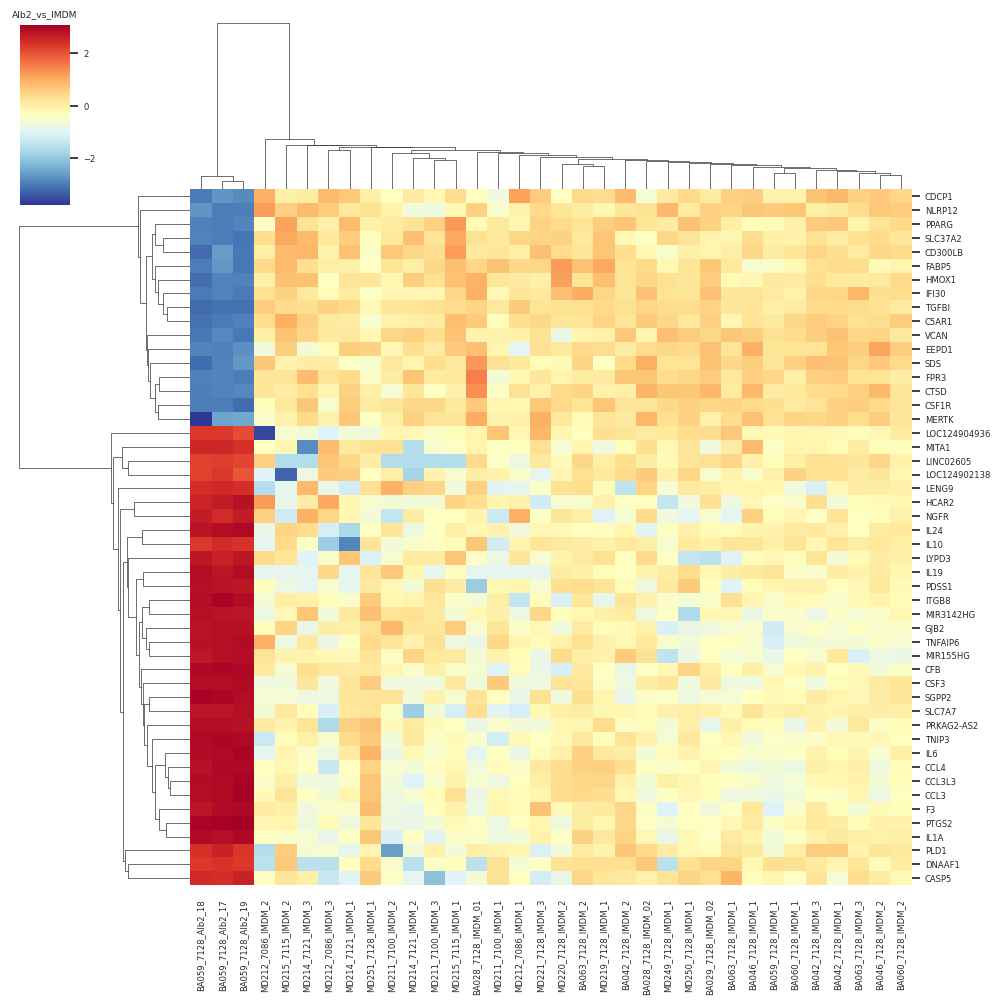

<Figure size 1200x1200 with 0 Axes>

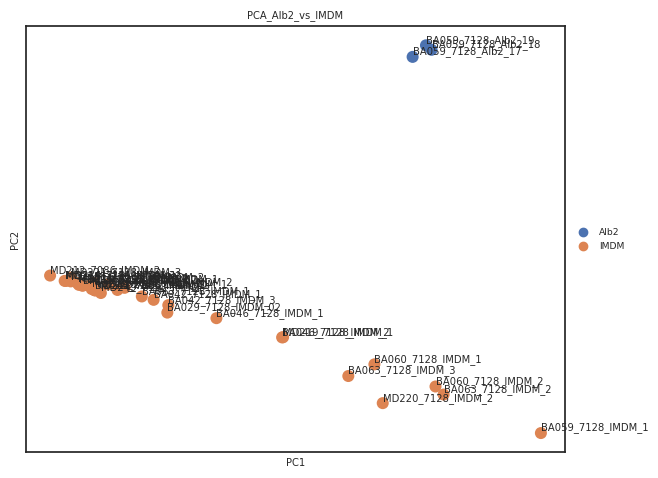

<Figure size 1200x1200 with 0 Axes>

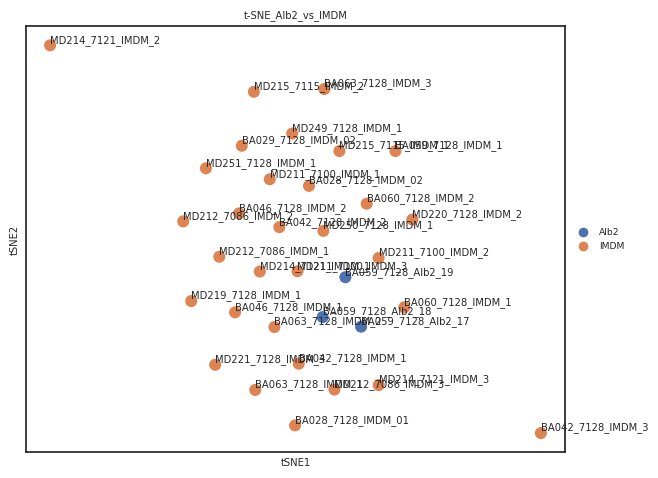

<Figure size 1200x1200 with 0 Axes>

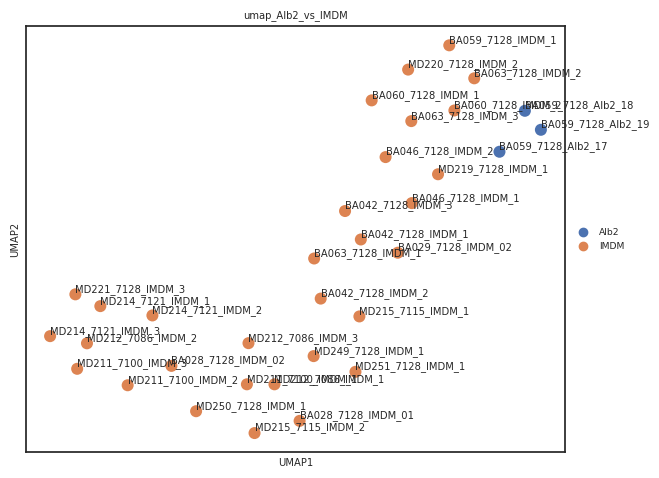

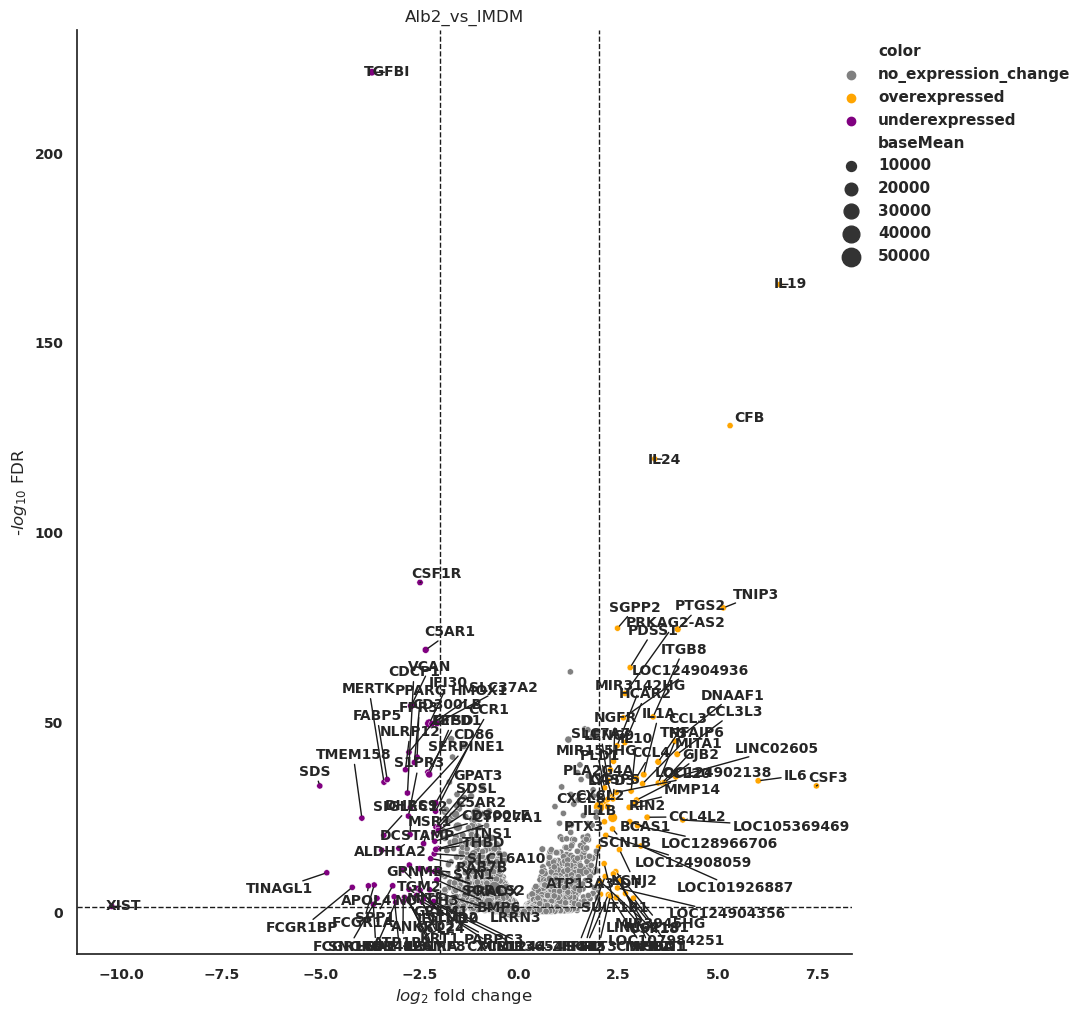

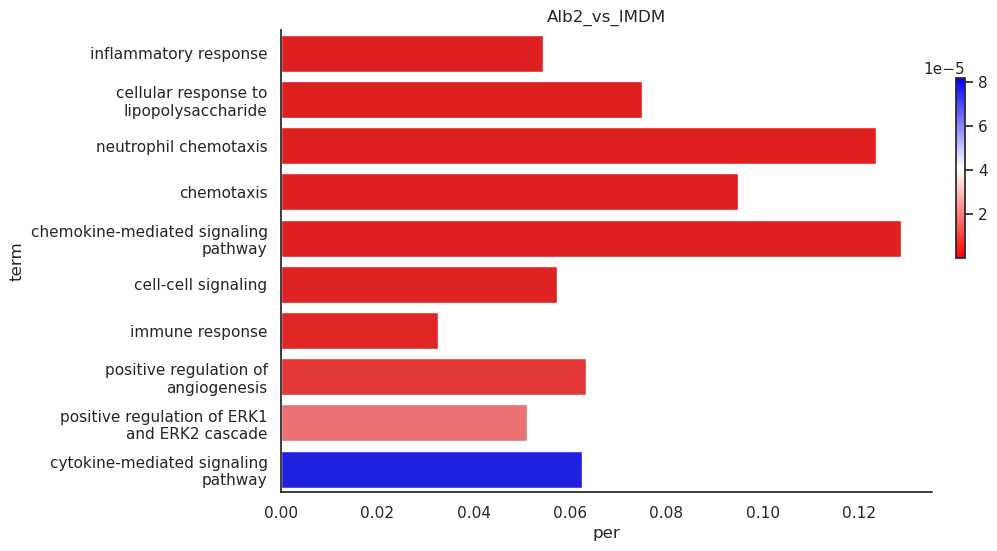

<Figure size 1200x1200 with 0 Axes>

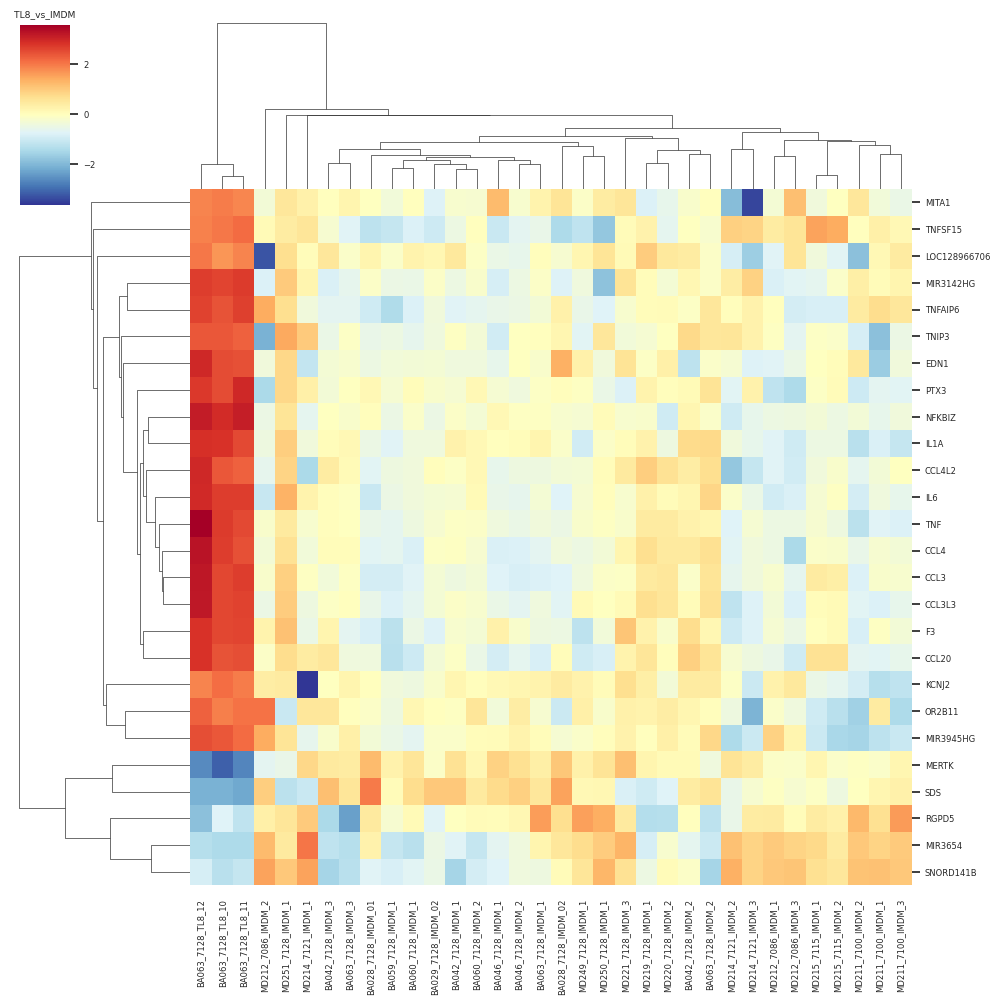

<Figure size 1200x1200 with 0 Axes>

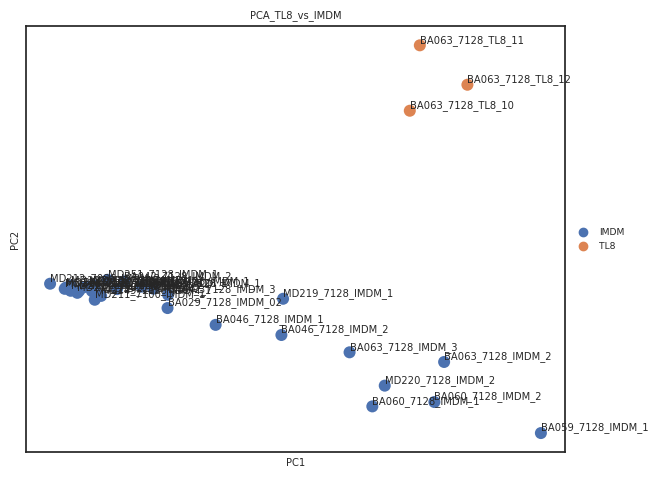

<Figure size 1200x1200 with 0 Axes>

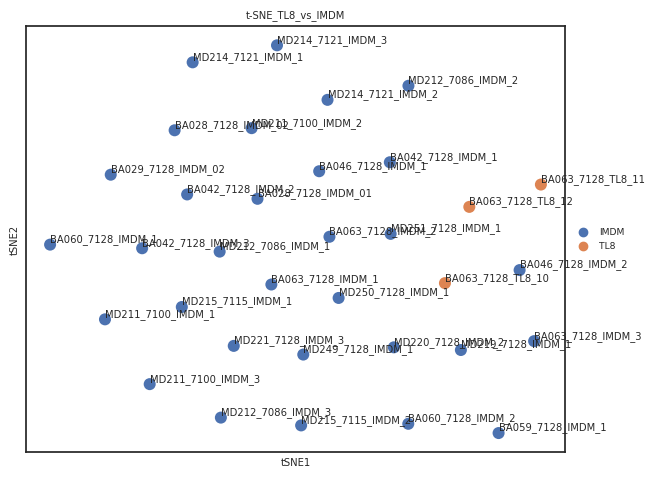

<Figure size 1200x1200 with 0 Axes>

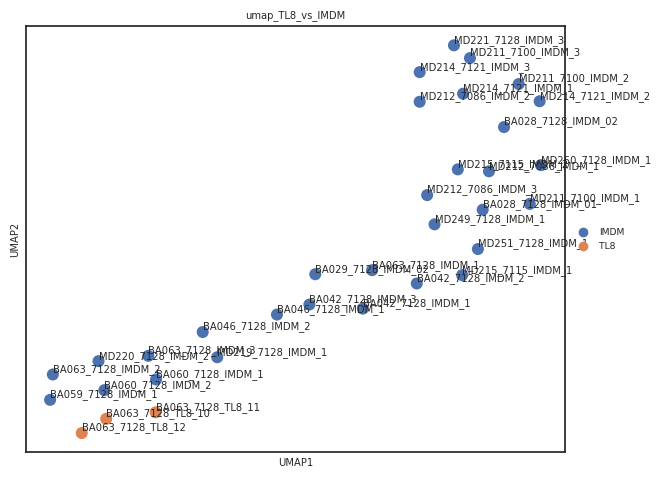

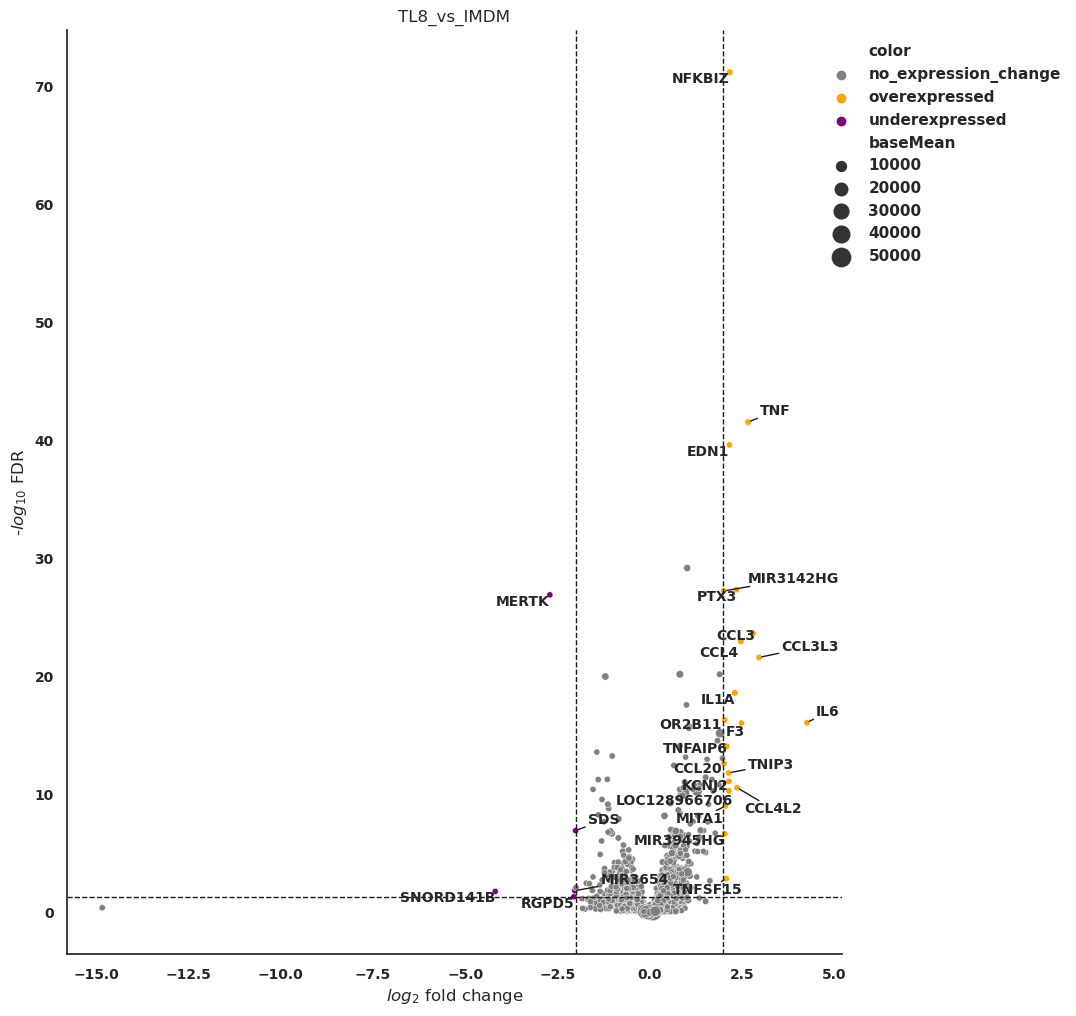

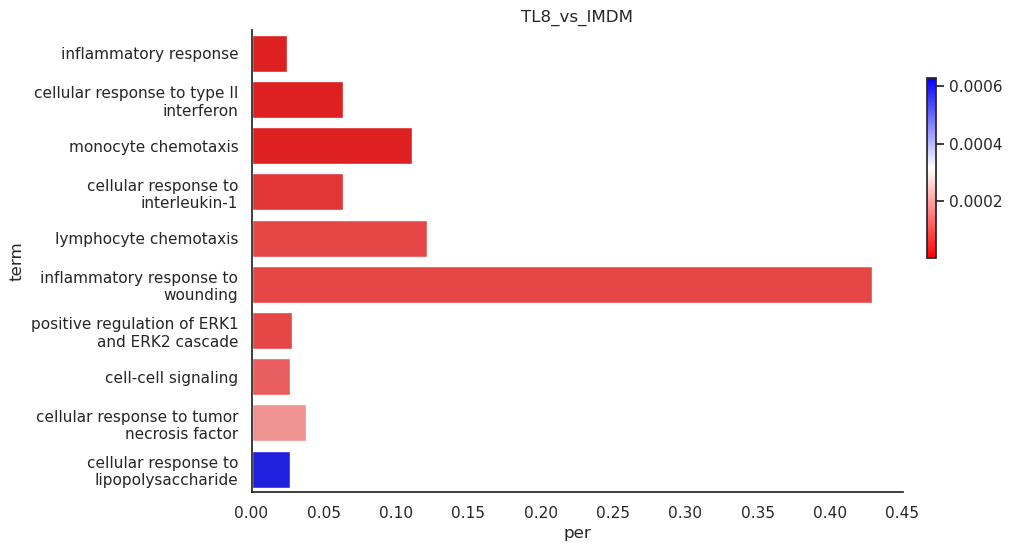

<Figure size 1200x1200 with 0 Axes>

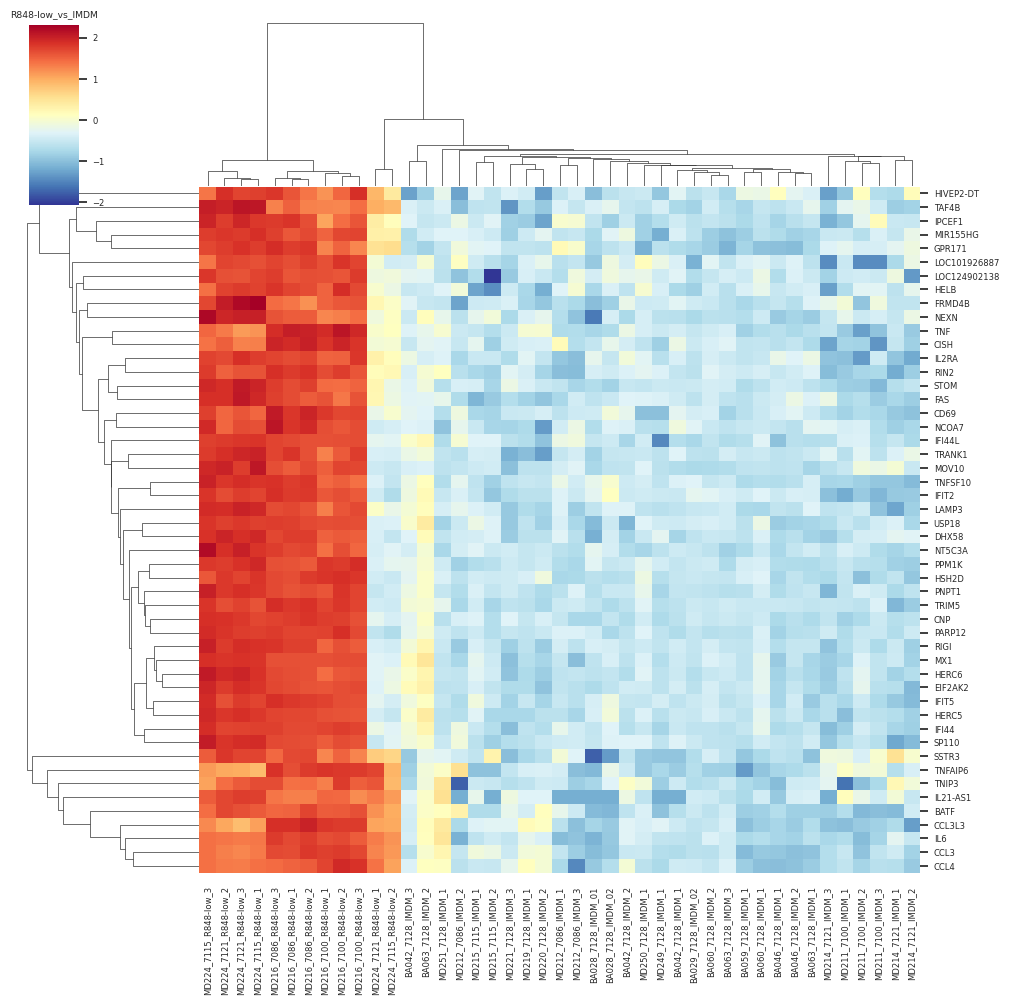

<Figure size 1200x1200 with 0 Axes>

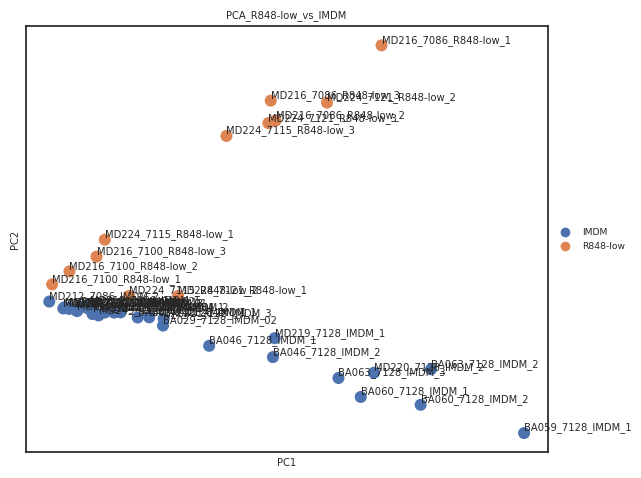

<Figure size 1200x1200 with 0 Axes>

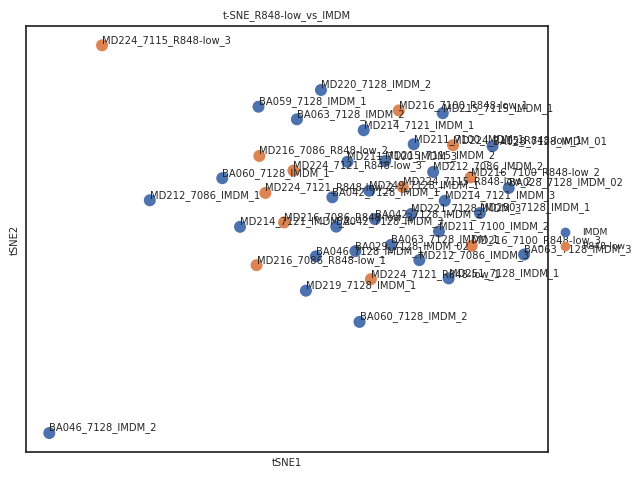

<Figure size 1200x1200 with 0 Axes>

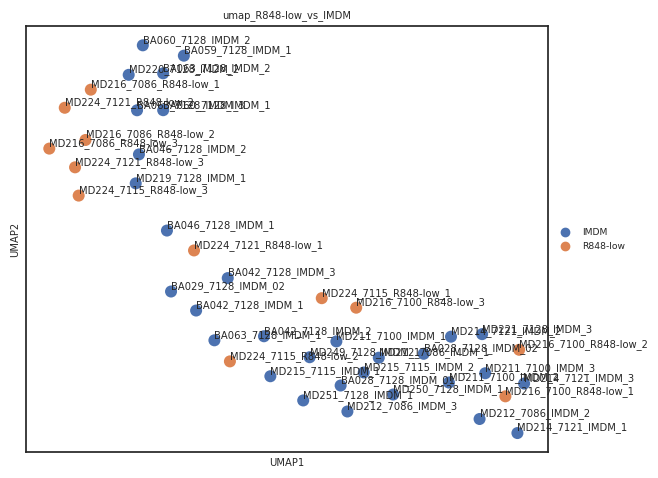

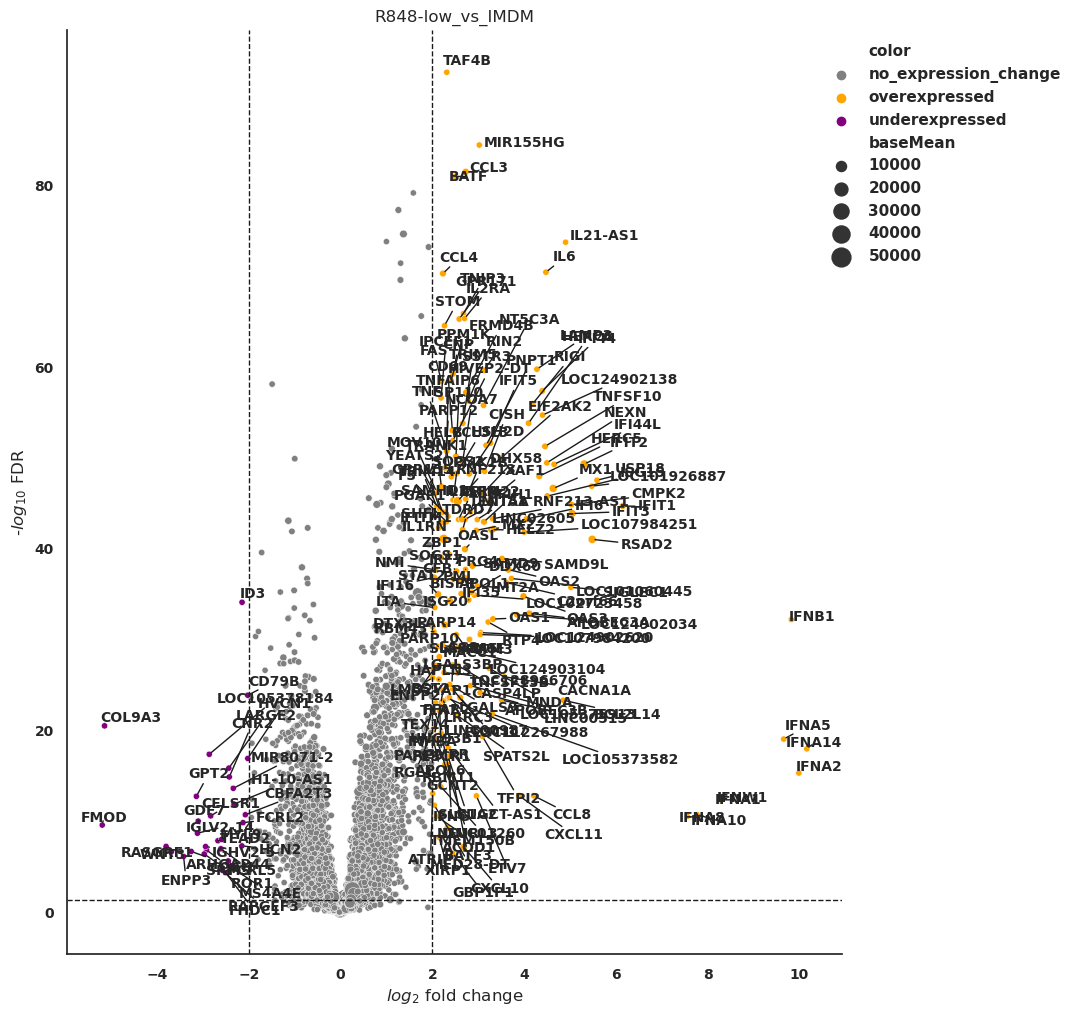

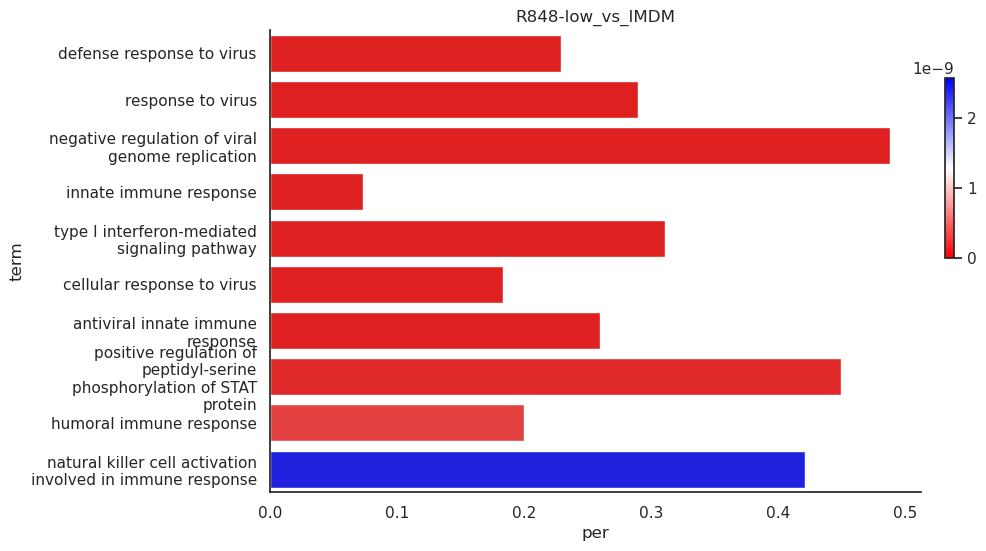

<Figure size 1200x1200 with 0 Axes>

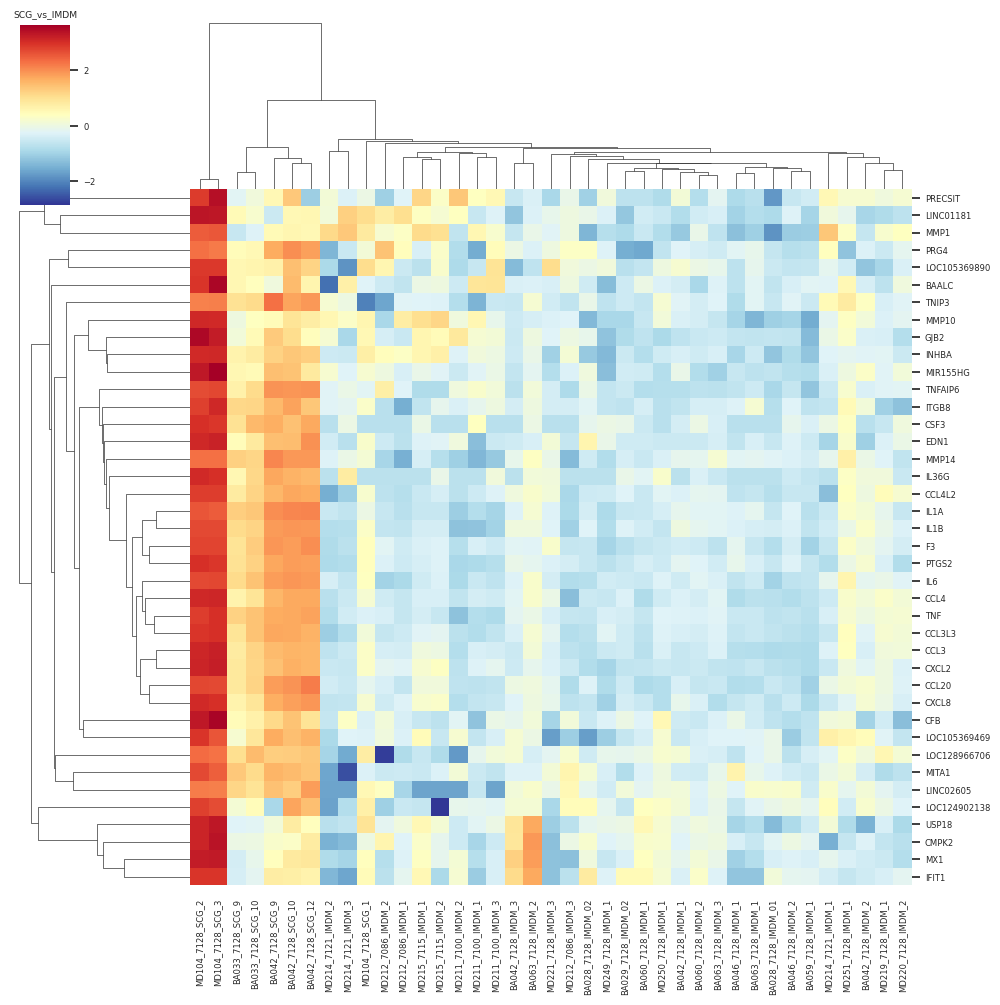

<Figure size 1200x1200 with 0 Axes>

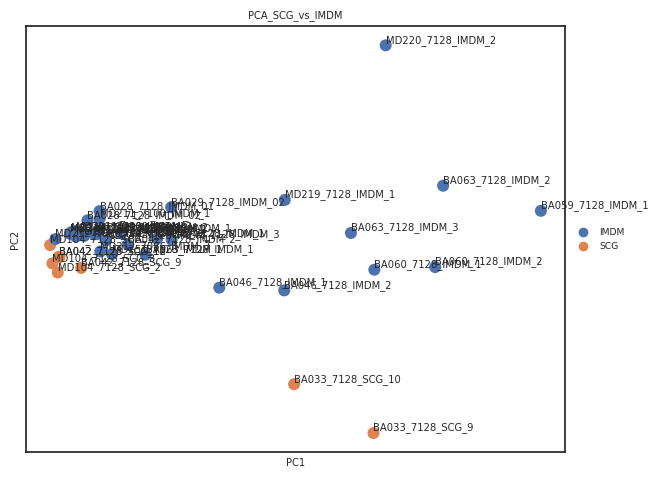

<Figure size 1200x1200 with 0 Axes>

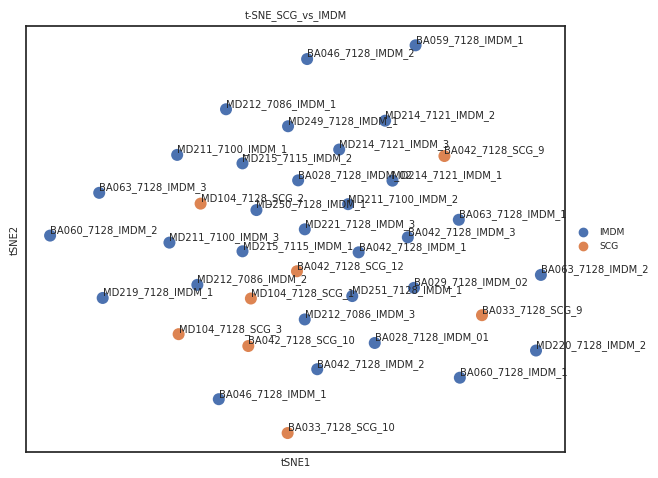

<Figure size 1200x1200 with 0 Axes>

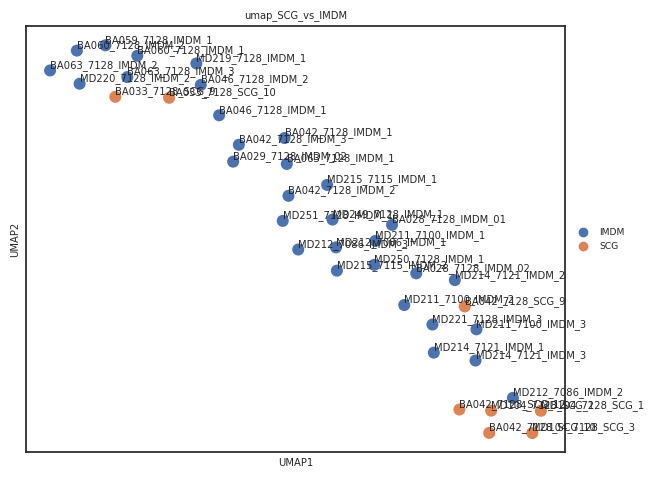

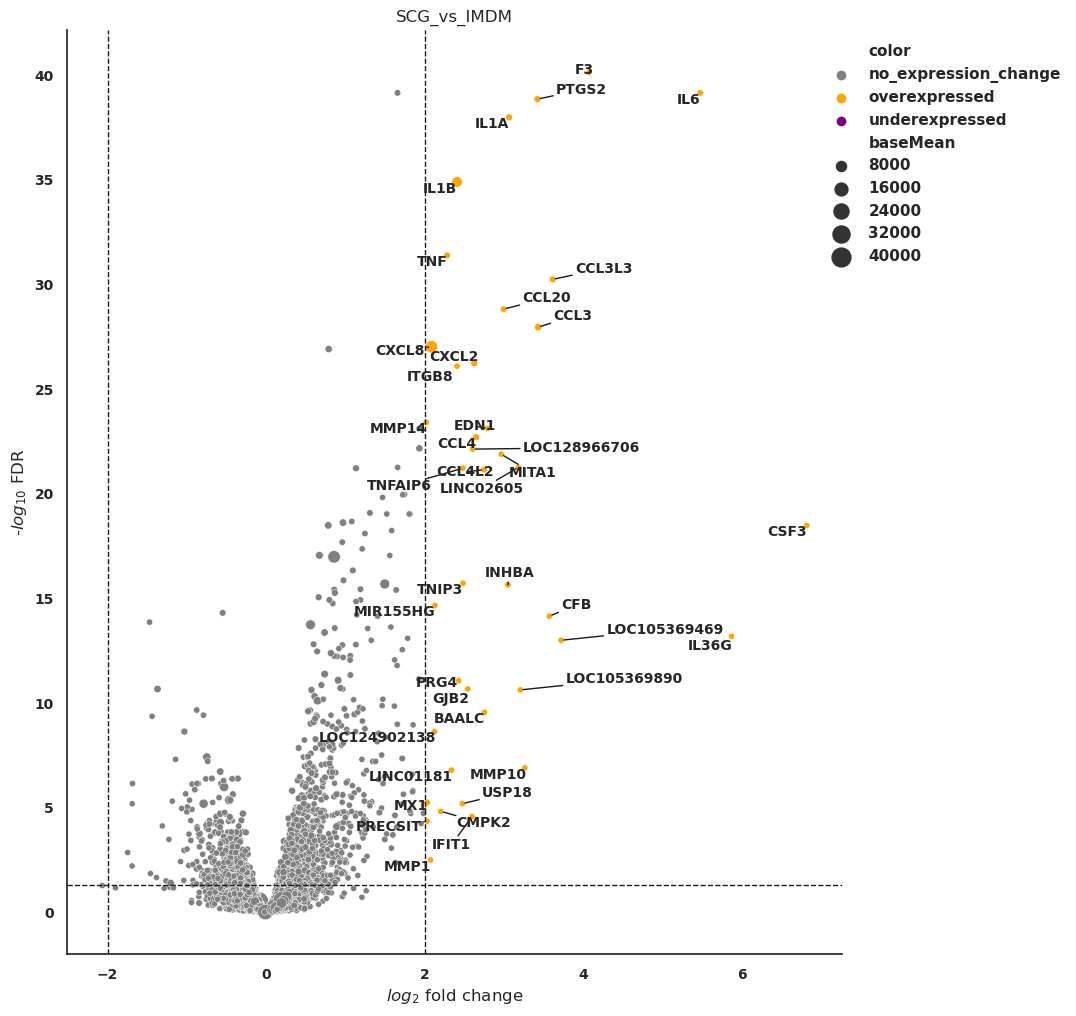

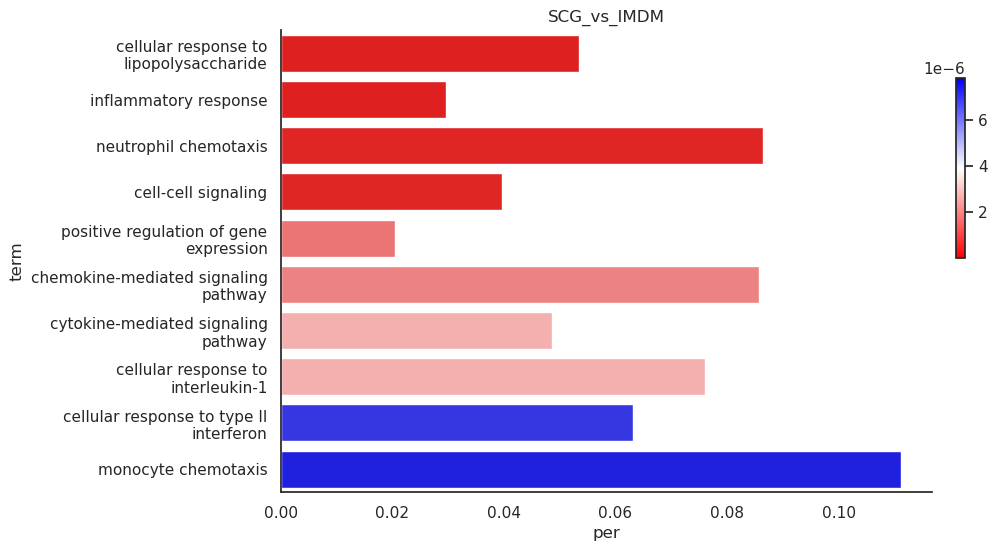

<Figure size 1200x1200 with 0 Axes>

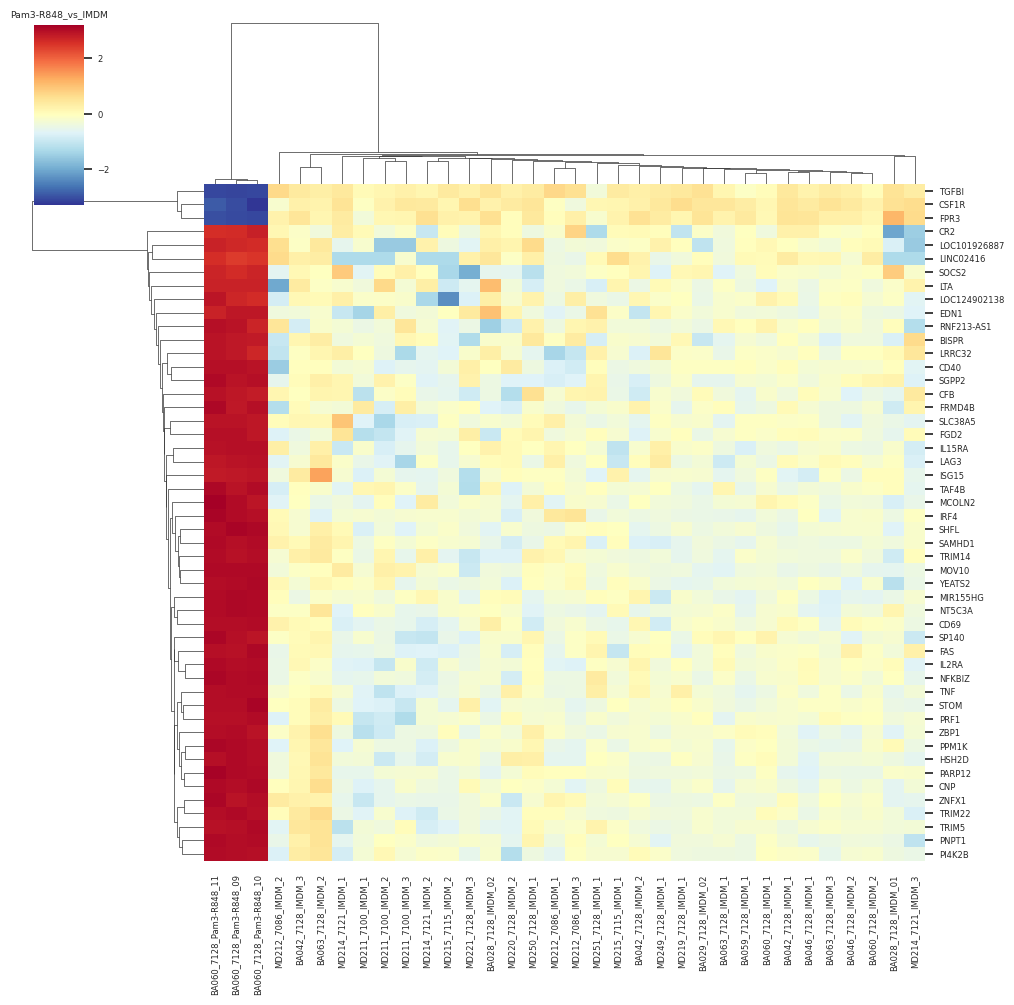

<Figure size 1200x1200 with 0 Axes>

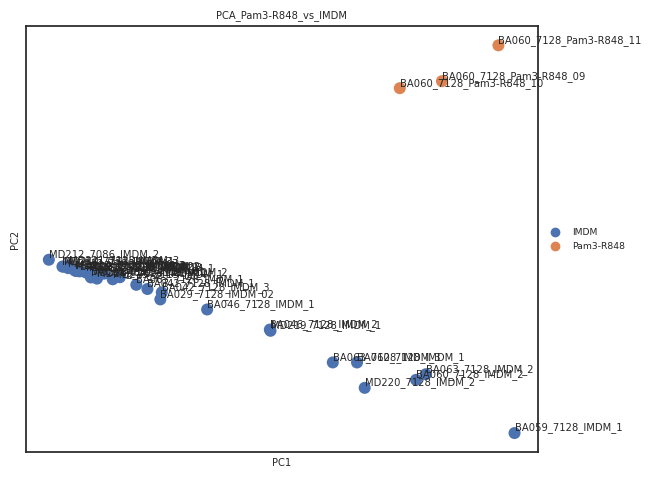

<Figure size 1200x1200 with 0 Axes>

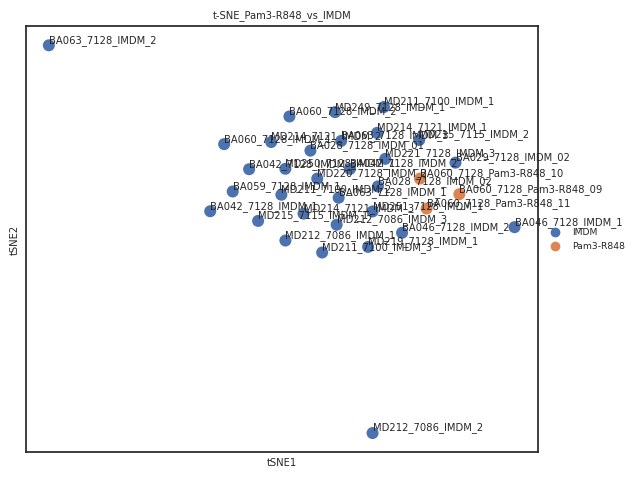

<Figure size 1200x1200 with 0 Axes>

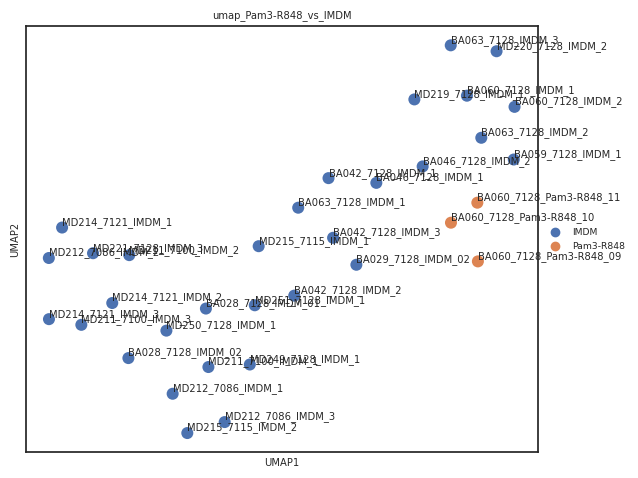

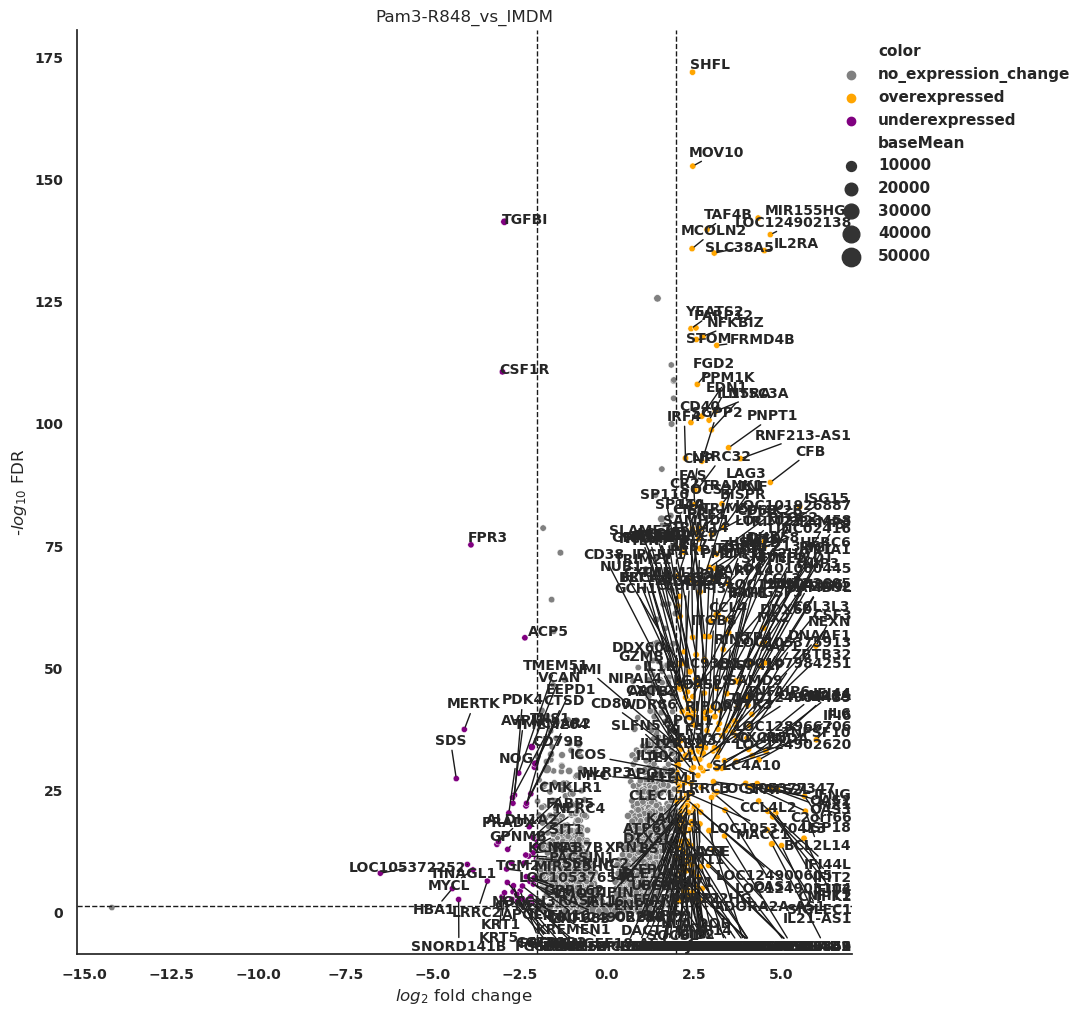

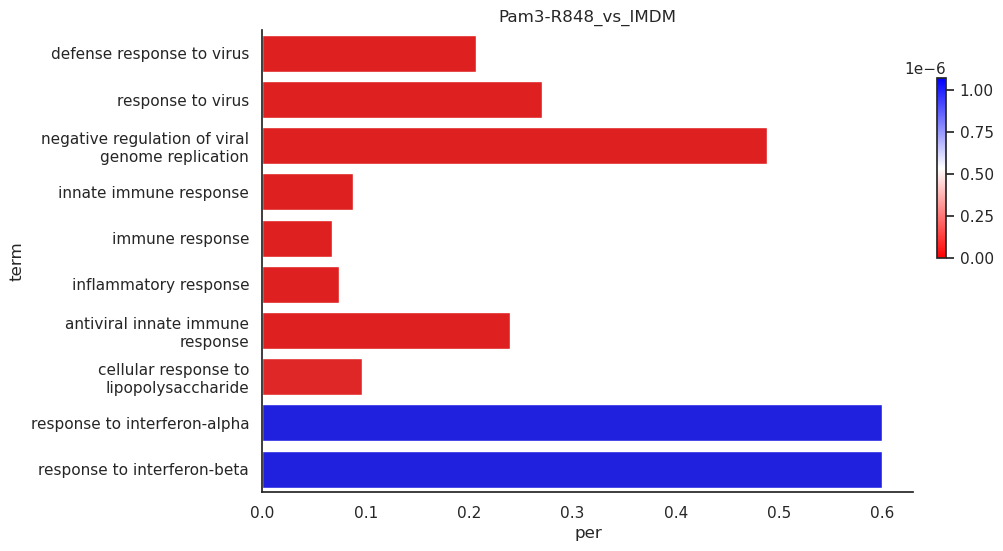

<Figure size 1200x1200 with 0 Axes>

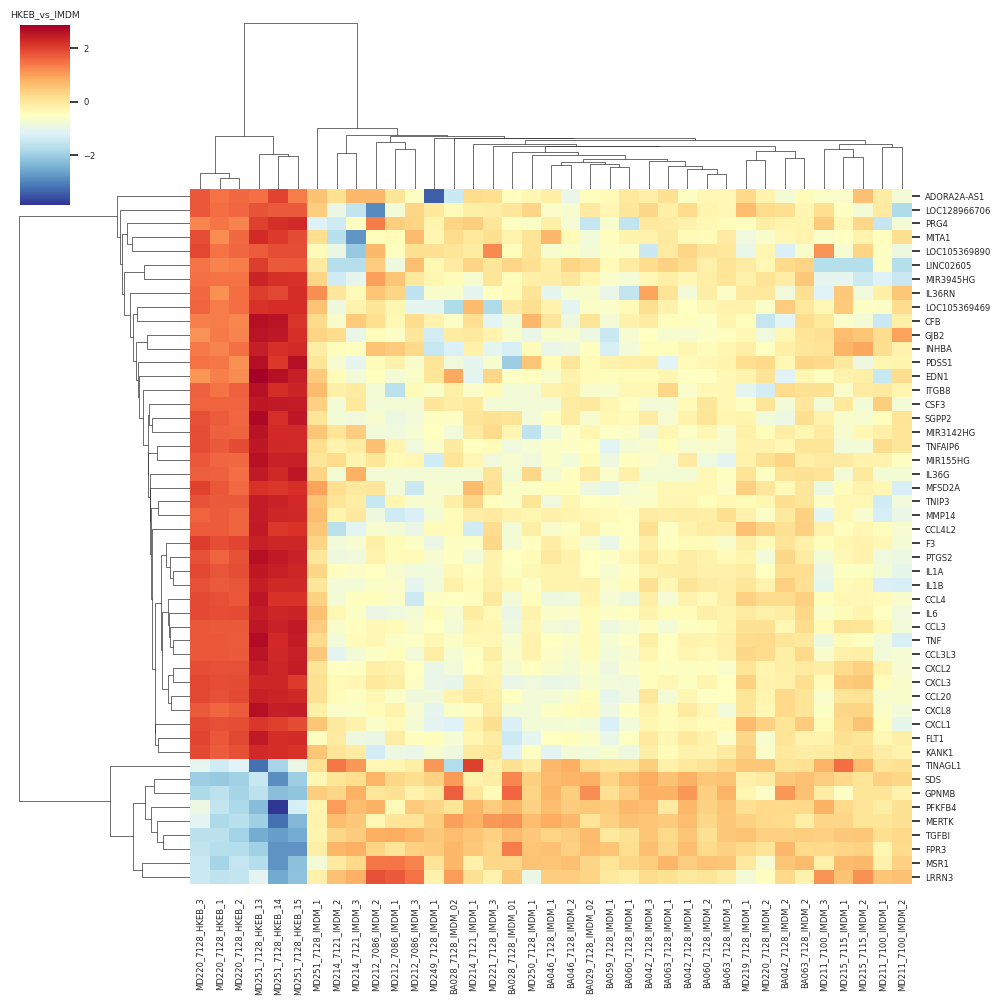

<Figure size 1200x1200 with 0 Axes>

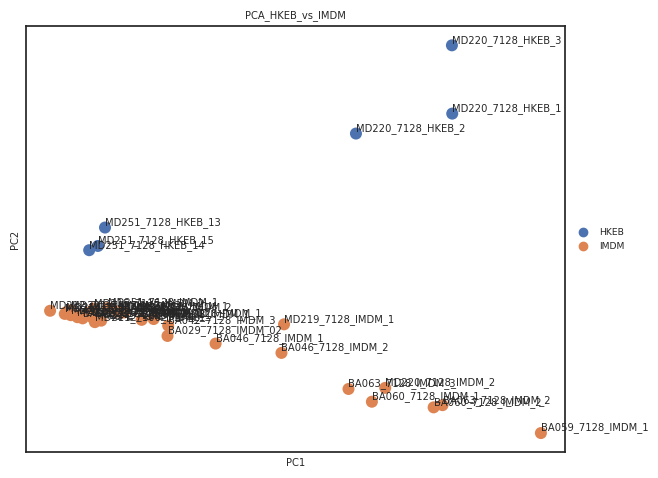

<Figure size 1200x1200 with 0 Axes>

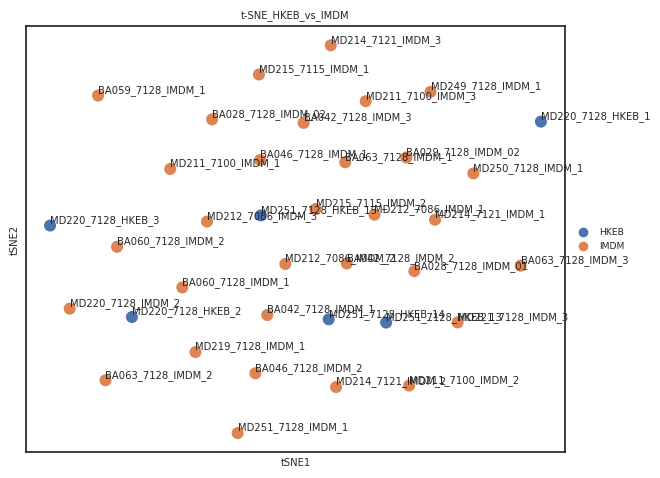

<Figure size 1200x1200 with 0 Axes>

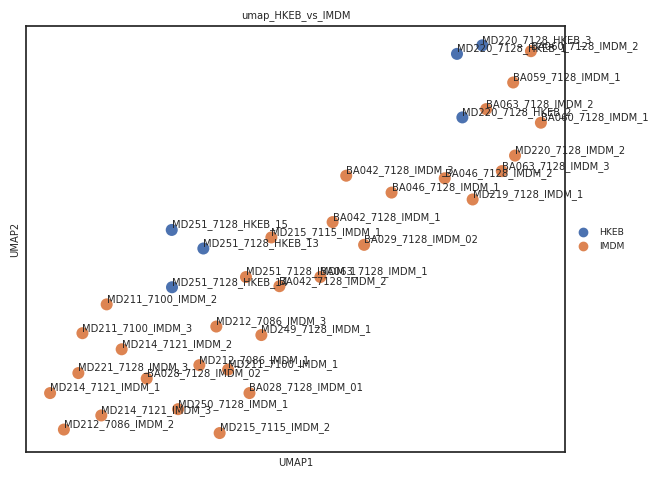

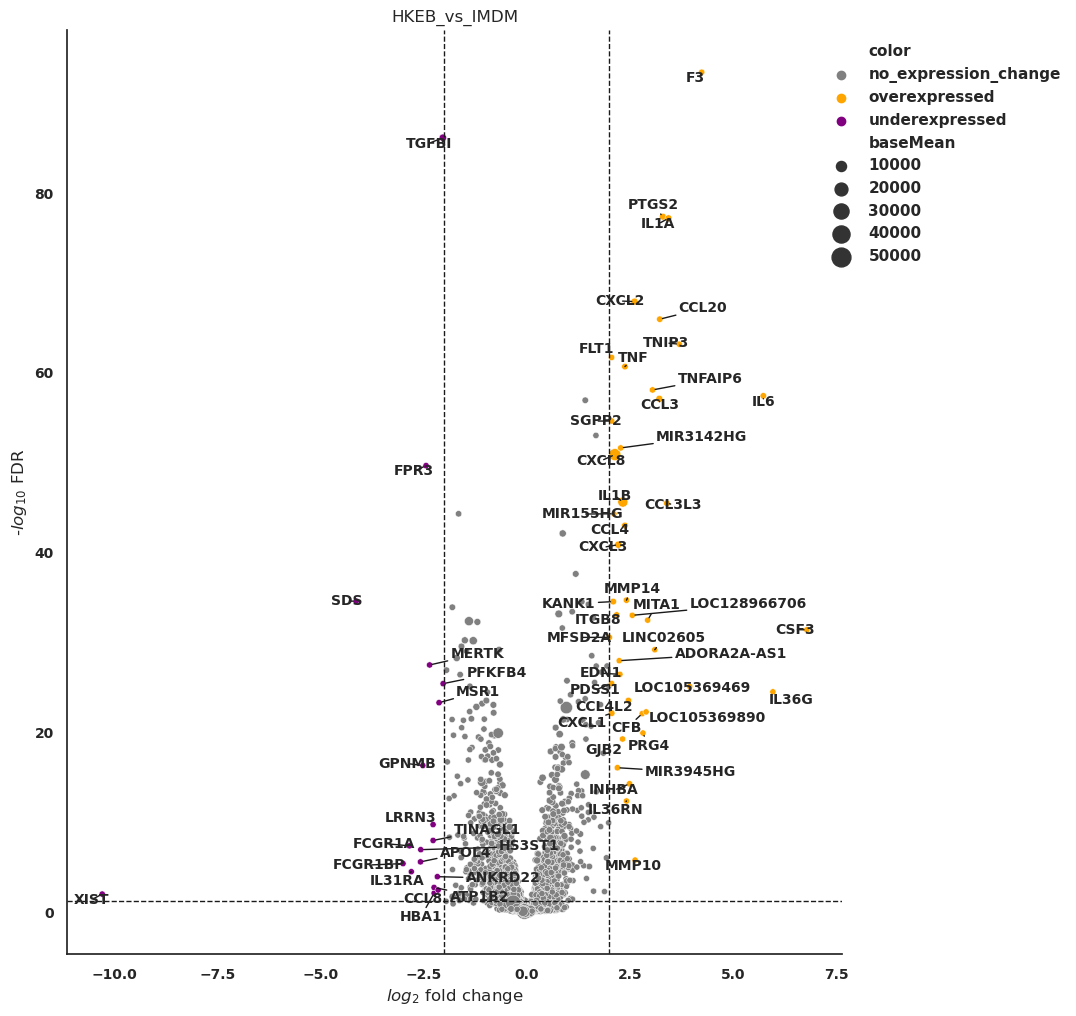

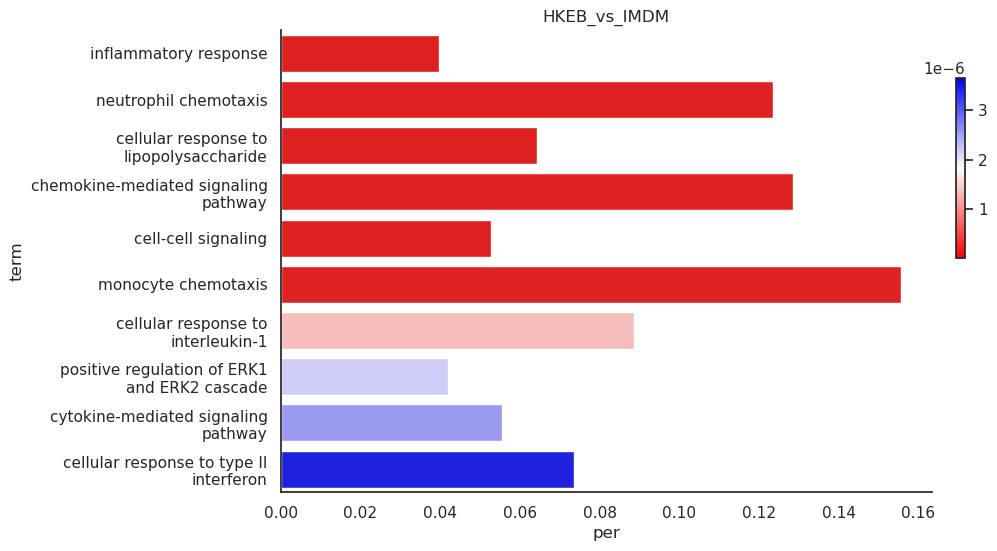

In [25]:
for class_pair in list_of_classes_to_include:
    analysis_name = f"{class_pair[0]}_vs_{class_pair[1]}"

    results_directory = os.path.join(current_directory, analysis_name)
    if os.path.exists(results_directory):
        continue
    else:
        os.makedirs(results_directory)

    dataprocessor = DataProcessor(
        raw_counts=raw_counts, classes=class_pair, batches=None, n_cpus=42
    )

    dds, res, sigs = dataprocessor.make_statistics()

    _ = make_historgram_for_sign_genes(
        dds, sigs, results_directory, analysis_name, num_top_sig=50
    )
    _ = make_pca(dds, results_directory, analysis_name)
    _ = make_tsne(dds, results_directory, analysis_name)
    _ = make_umap(dds, results_directory, analysis_name)
    _ = make_volcano_plot(
        res,
        results_directory,
        analysis_name,
    )
    go_df = go_it(
        sigs.index, mapper, goeaobj, go_items
    )  # Crashes here if go lsit is empty
    _ = make_go_plot(go_df[0:10], results_directory, analysis_name)